### K-matrix with the poles and background poles
\begin{equation*}
K^J_{ki}(s) = \sum_R \frac{g^{(R)}_k g^{(R)}_i}{m_R^2 - s} + c^J_{ki} + d^J_{ki} s
\end{equation*}

In [1]:
function K(s, pars)
    kmatpars = pars[1]
    v = Matrix{Complex{Float64}}(2,2); v .= 0.0
    for k in kmatpars
        mi = k[1]
        gi = k[2]
        v += [gi[1]^2 gi[1]*gi[2]; gi[1]*gi[2] gi[2]^2] ./ (mi^2-s)
    end
    bkgpars = pars[2]
    for (i,pars) in enumerate(bkgpars)
        v += [pars[1] pars[3]; pars[3] pars[2]] .* s^(i-1)
    end
    v
end

K (generic function with 1 method)

In [2]:
const mπ = 0.13957
const mπ2 = mπ^2
const mη = 0.54786
const mη2 = mη^2
const mηp = 0.95778 
const mηp2 = mηp^2;

In [3]:
using QuadGK

### The scattering matrix in the denominator
\begin{equation*}
\rho N^J_{ki}(s') = g \,\delta_{ki} \,\frac{\lambda^{J+1/2}\left(s',m_{\eta^{(\prime)}}^2,m_\pi^2\right)}{\left(s'+s_R\right)^{2J+1+\alpha}} \label{eq:rhoN}
\end{equation*}

\begin{equation*}
\mathrm{DISP}\,\rho N^J_{ki}(s) = \frac{s}{\pi}\int_{s_{k}}^{\infty}ds'\frac{\rho N^J_{ki}(s') }{s'(s'-s - i\epsilon)}, 
\end{equation*}

In [4]:
λ(x,y,z) = x^2+y^2+z^2-2x*y-2y*z-2z*x
# just expressoion
ρN(s,m1sq,m2sq,J,g,α,sR) = g*sqrt(λ(s,m1sq,m2sq))^(2J+1)/(s+sR)^(2J+1+α)
# Dispersive integral
ρNdisp(s,m1sq,m2sq,J,g,α,sR) = s/π*quadgk(x->ρN(x,m1sq,m2sq,J,g,α,sR)/(x*(x-s-1e-5im)), (√m1sq+√m2sq)^2, Inf)[1]
ρNdisp(s,J,g,α,sR) = [ρNdisp(s,mη2,mπ2,J,g,α,sR) 0.0; 0.0 ρNdisp(s,mηp2,mπ2,J,g,α,sR)]

ρNdisp (generic function with 2 methods)

$$
D^J_{ki}(s) =  \left[ {K^J(s)}^{-1}\right]_{ki} - \mathrm{DISP}\,\rho N^J_{ki}(s), 
$$

In [7]:
Dinv(ρN,K) = K*inv(eye(2)-ρN*K)
#
function DinvPwave(s)
    # Parameters
    mP = sqrt(3.52)
    gP = [-0.55, -13.12]
    kmatparsP = [(mP,gP)]
    bkgP = ([-14.77,-184.19,-65.28],[1.93,60.54,7.59])
    parsP = (kmatparsP,bkgP)
    JP = 1
    αP = 1
    sR = 1.0
    # call function
    Dinv(ρNdisp(s,JP,1,αP,sR),K(s,parsP))
end
#
function DinvDwave(s)
    # Parameters
    mD1 = sqrt(1.86)
    gD1 = [5.64, -3.78]
    mD2 = sqrt(8.06)
    gD2 = [147.17, -34.07]
    kmatparsD = ((mD1,gD1),(mD2,gD2))
    bkgD = ([-2385.05,-92.25,469.55],[-608.35,-44.45,166.85])
    parsD = (kmatparsD,bkgD)
    JD = 2
    αD = 1
    sR = 1.0
    # call function
    Dinv(ρNdisp(s,JD,1,αD,sR),K(s,parsD))
end

DinvDwave (generic function with 1 method)

In [8]:
const cheb = [x->1.0,
        x->x,
        x->2*x^2-1,
        x->4x^3-3];
function n(s,pars)
    Λ = 1.0
    ω = s/(s+Λ)
    v = 0.0
    for (i,p) in enumerate(pars)
        v += p*cheb[i](ω)
    end
    v
end

n (generic function with 1 method)

In [9]:
function nP(s)
    [n(s,[356.0,-547.0,240.0,-47.])  n(s,[-43.0,59.0,-17.0,0.0])]
end
function nD(s)
    [n(s,[-247.0,415.0,-192.0,61.0]) n(s,[233.0,-290.0,177.0,-1.0])]
end

nD (generic function with 1 method)

In [10]:
p(s) = sqrt.([s<(mη+mπ)^2 ? 0.0 : λ(s,mη2,mπ2)/(4s), 
              s<(mηp+mπ)^2 ? 0.0 : λ(s,mηp2,mπ2)/(4s)])
function q(s)
    teff = -0.1
    sqrt(λ(s,teff,mπ2))/(2*√s)
end

q (generic function with 1 method)

In [11]:
aP(s) = nP(s)*DinvPwave(s).*p(s)
aD(s) = nD(s)*DinvDwave(s).*(p(s) .^ 2) .* q(s)

aD (generic function with 1 method)

In [12]:
ev = linspace(0.8,2,100)
calP = [aP(e^2) for e in ev];
calD = [aD(e^2) for e in ev];

In [13]:
using Plots

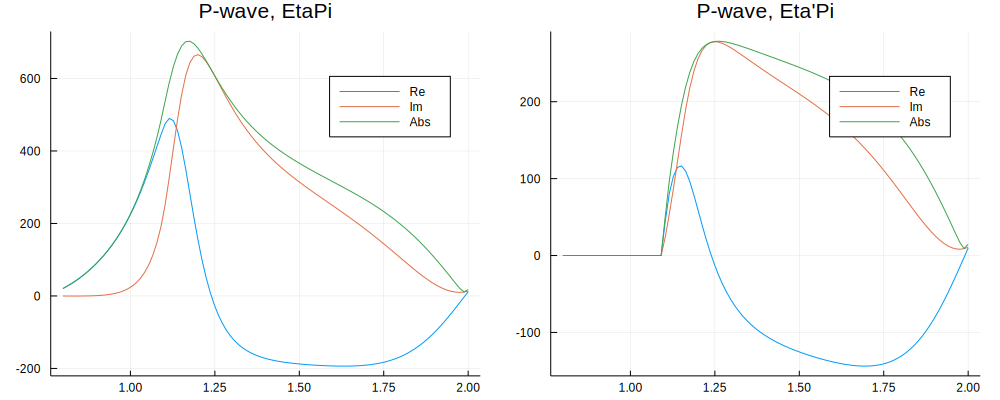

In [14]:
plot(
    plot(ev, [
            broadcast(x->real(x[1]), calP),
            broadcast(x->imag(x[1]), calP),
            broadcast(x-> abs(x[1]), calP)
            ], title="P-wave, EtaPi", lab=["Re" "Im" "Abs"]),
    plot(ev, [
            broadcast(x->real(x[2]), calP),
            broadcast(x->imag(x[2]), calP),
            broadcast(x-> abs(x[2]), calP)
            ], title="P-wave, Eta'Pi", lab=["Re" "Im" "Abs"]),
    size=(1000,400)
)

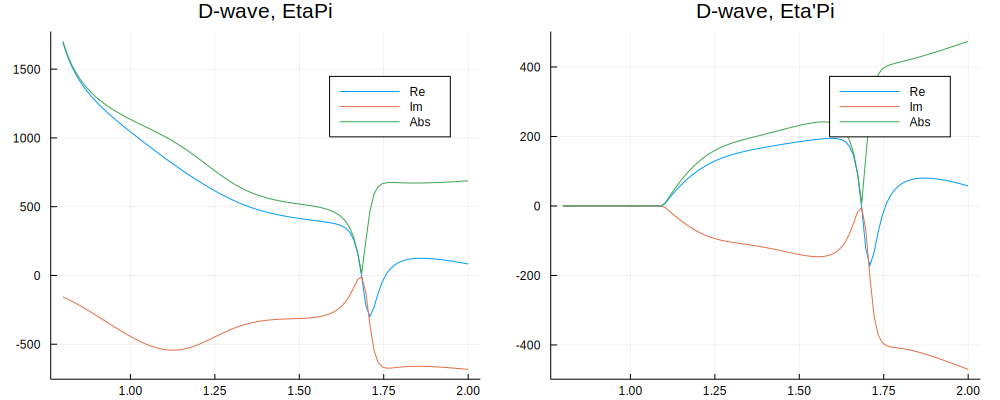

In [15]:
plot(
    plot(ev, [
            broadcast(x->real(x[1]), calD),
            broadcast(x->imag(x[1]), calD),
            broadcast(x-> abs(x[1]), calD)
            ], title="D-wave, EtaPi", lab=["Re" "Im" "Abs"]),
    plot(ev, [
            broadcast(x->real(x[2]), calD),
            broadcast(x->imag(x[2]), calD),
            broadcast(x-> abs(x[2]), calD)
            ], title="D-wave, Eta'Pi", lab=["Re" "Im" "Abs"]),
    size=(1000,400)
)

In [16]:
arg(z) = atan2(imag(z), real(z))
function IPDϕ(s,ampP,ampD)
    IP = abs2.(ampP) .* p(s)
    ID = abs2.(ampD) .* p(s)
    Phi = arg.(ampP .* conj.(ampD))
    IP, ID, Phi
end

IPDϕ (generic function with 1 method)

In [17]:
ev = linspace(0.8,2,100)
cal = [IPDϕ(e^2,aP(e^2),aD(e^2)) for e in ev];

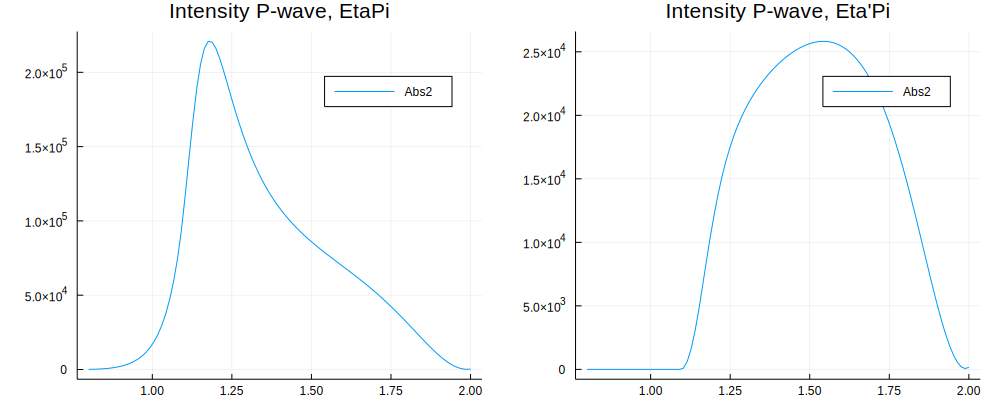

In [18]:
plot(
    plot(ev, broadcast(x->x[1][1], cal), title="Intensity P-wave, EtaPi", lab="Abs2"),
    plot(ev, broadcast(x->x[1][2], cal), title="Intensity P-wave, Eta'Pi", lab="Abs2"),
    size=(1000,400)
)

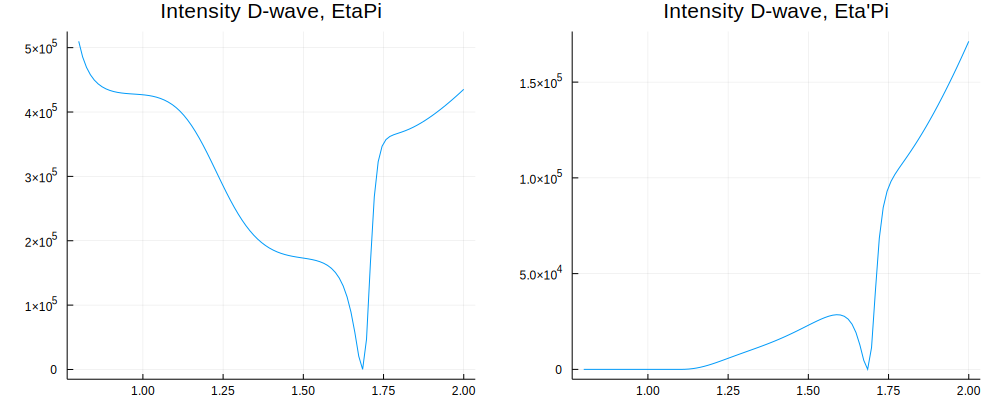

In [19]:
plot(
    plot(ev, broadcast(x->x[2][1], cal), title="Intensity D-wave, EtaPi", lab=""),
    plot(ev, broadcast(x->x[2][2], cal), title="Intensity D-wave, Eta'Pi", lab=""),
    size=(1000,400)
)

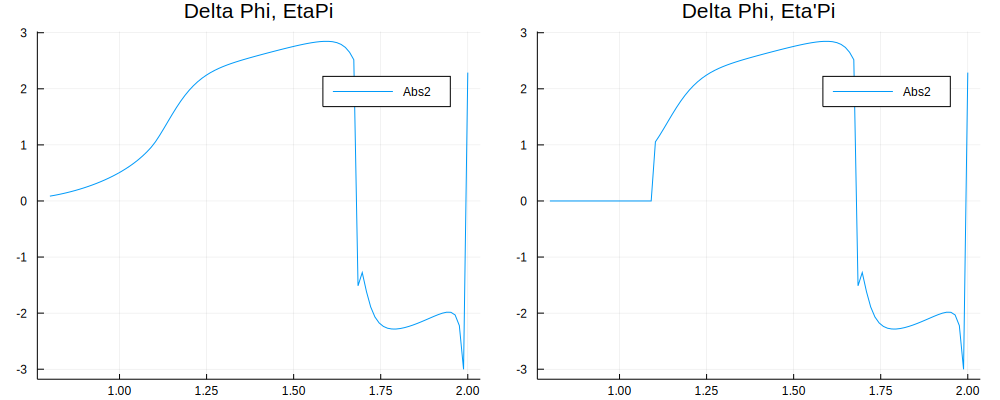

In [20]:
plot(
    plot(ev, broadcast(x->x[3][1], cal), title="Delta Phi, EtaPi", lab="Abs2"),
    plot(ev, broadcast(x->x[3][2], cal), title="Delta Phi, Eta'Pi", lab="Abs2"),
    size=(1000,400)
)